## Imports and settings

In [1]:
# Fix randomness and hide warnings
seed = 1234

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [3]:
# Check if tensorflow is using GPU
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import utils

## Load the data

In [5]:
T1_samples_loaded, T2_samples_loaded, T1_labels_loaded, T2_labels_loaded = utils.load_preprocessed_data_train()

## Prepare the data for the network

In [6]:
T1_data_samples, T2_data_samples, T1_data_labels, T2_data_labels = utils.prepare_data_for_training(T1_samples_loaded, T2_samples_loaded, T1_labels_loaded, T2_labels_loaded)

Preparing T1 samples for training...
- Vertically stacking the samples from all patients...
- Adding a channel dimension to the samples...
- Normalizing the samples with min-max scaling...
Samples shape: (640, 272, 272, 1)

Preparing T2 samples for training...
- Vertically stacking the samples from all patients...
- Adding a channel dimension to the samples...
- Normalizing the samples with min-max scaling...
Samples shape: (640, 272, 272, 1)

Preparing T1 labels for training...
- Vertically stacking the labels from all patients...
- Creating masks for the different categories...
Labels shape: (640, 272, 272, 1)

Preparing T2 labels for training...
- Vertically stacking the labels from all patients...
- Creating masks for the different categories...
Labels shape: (640, 272, 272, 1)


In [7]:
# Vertically stack the T1 and T2 data (samples and labels)
data_samples = np.vstack((T1_data_samples, T2_data_samples))
data_labels = np.vstack((T1_data_labels, T2_data_labels))

# Print the shape of the data
print(data_samples.shape)
print(data_labels.shape)

(1280, 272, 272, 1)
(1280, 272, 272, 1)


In [8]:
# Split the data into training, validation and test sets
X_train, X_val, X_test, y_train, y_val, y_test = utils.split_data_for_training(data_samples, data_labels)

Splitting the data into training, validation and test sets...
    Train samples shape: (880, 272, 272, 1)
    Train labels shape: (880, 272, 272, 1)
    Validation samples shape: (200, 272, 272, 1)
    Validation labels shape: (200, 272, 272, 1)
    Test samples shape: (200, 272, 272, 1)
    Test labels shape: (200, 272, 272, 1)


In [9]:
# Define input parameters
input_shape = X_train[0].shape
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (272, 272, 1)
Number of classes: 5


## Create the model and a custom IOU metric

In [10]:
# Create the UNet model
unet_model = utils.get_unet_model(input_shape=T1_data_samples[0].shape, num_classes=len(np.unique(T1_data_labels)))
unet_model.summary()

Model: "unet_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 272, 272, 1)]        0         []                            
                                                                                                  
 down_block1_conv1 (Conv2D)  (None, 272, 272, 64)         640       ['input_layer[0][0]']         
                                                                                                  
 down_block1_bn1 (BatchNorm  (None, 272, 272, 64)         256       ['down_block1_conv1[0][0]']   
 alization)                                                                                       
                                                                                                  
 down_block1_act1 (Activati  (None, 272, 272, 64)         0         ['down_block1_bn1[0][

In [11]:
# Define a custom metric class for mean intersection over union (IoU)
@keras.utils.register_keras_serializable()
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes=None, name="mean_iou", dtype=None):
        super(UpdatedMeanIoU, self).__init__(num_classes=num_classes, name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

## Train the model

In [12]:
# Free up RAM
del T1_samples_loaded, T2_samples_loaded, T1_labels_loaded, T2_labels_loaded, T1_data_samples, T2_data_samples, T1_data_labels, T2_data_labels, data_samples, data_labels

In [13]:
# Define hyperparameters
learning_rate = 1e-3
batch_size = 8
epochs = 1000

# Define compile parameters
loss = 'sparse_categorical_crossentropy'
optimizer = keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-3)
metrics = ['accuracy', UpdatedMeanIoU(num_classes=num_classes)]

# Define callbacks
patience = 30
early_stopping = keras.callbacks.EarlyStopping(monitor='val_mean_iou', mode='max', patience=patience, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_mean_iou', mode='max', factor=0.1, patience=patience-5, min_lr=1e-6)

In [14]:
# Compile the model
unet_model.compile(loss=loss, optimizer=optimizer, metrics=metrics, jit_compile=True)

In [15]:
# Train the model
history = unet_model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/1000


I0000 00:00:1702161174.956947   64892 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


110/110 [==============================] - 86s 217ms/step - loss: 0.1958 - accuracy: 0.9444 - mean_iou: 0.1970 - val_loss: 0.2681 - val_accuracy: 0.9087 - val_mean_iou: 0.2135 - lr: 0.0010
Epoch 2/1000
110/110 [==============================] - 22s 197ms/step - loss: 0.0861 - accuracy: 0.9716 - mean_iou: 0.3033 - val_loss: 0.4899 - val_accuracy: 0.7372 - val_mean_iou: 0.1650 - lr: 0.0010
Epoch 3/1000
110/110 [==============================] - 22s 198ms/step - loss: 0.0705 - accuracy: 0.9767 - mean_iou: 0.3835 - val_loss: 0.2636 - val_accuracy: 0.9468 - val_mean_iou: 0.1903 - lr: 0.0010
Epoch 4/1000
110/110 [==============================] - 22s 198ms/step - loss: 0.0648 - accuracy: 0.9777 - mean_iou: 0.4045 - val_loss: 0.5396 - val_accuracy: 0.7665 - val_mean_iou: 0.1787 - lr: 0.0010
Epoch 5/1000
110/110 [==============================] - 22s 199ms/step - loss: 0.0555 - accuracy: 0.9804 - mean_iou: 0.4638 - val_loss: 0.1906 - val_accuracy: 0.9449 - val_mean_iou: 0.2292 - lr: 0.0010
Epo

## Visualize the results

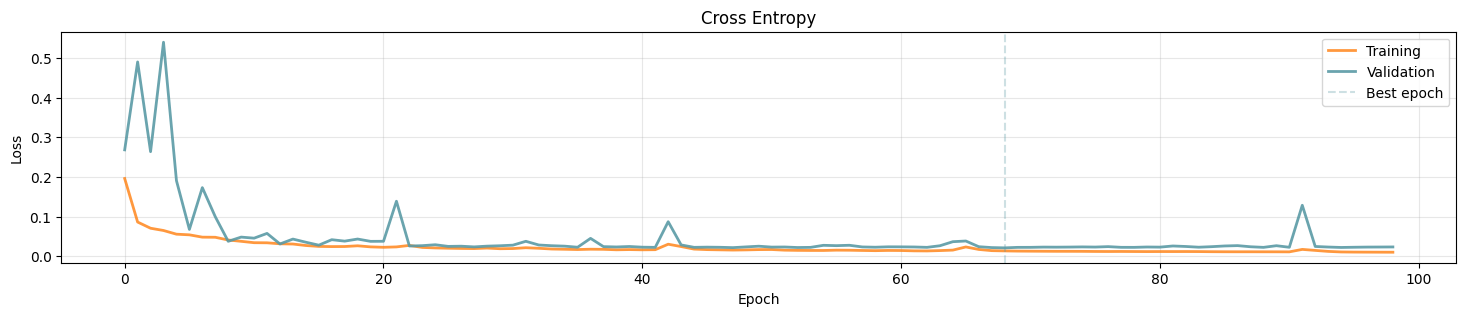

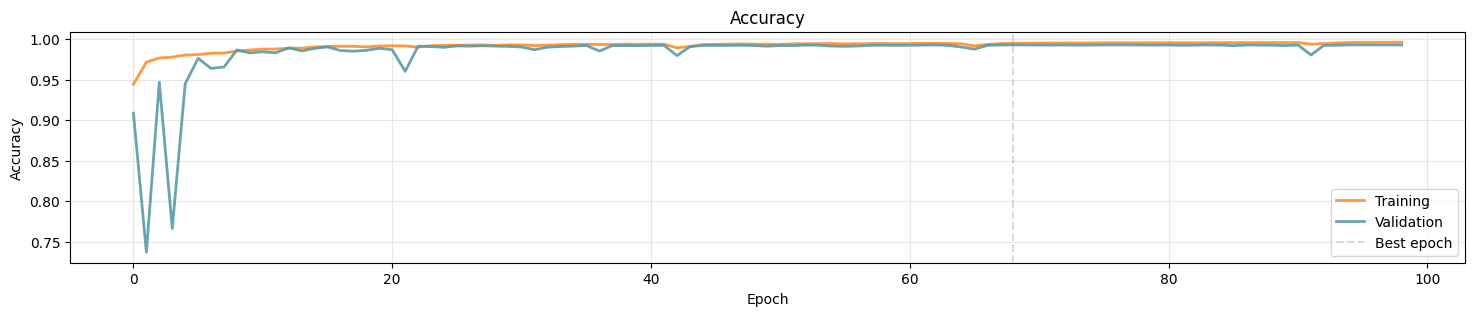

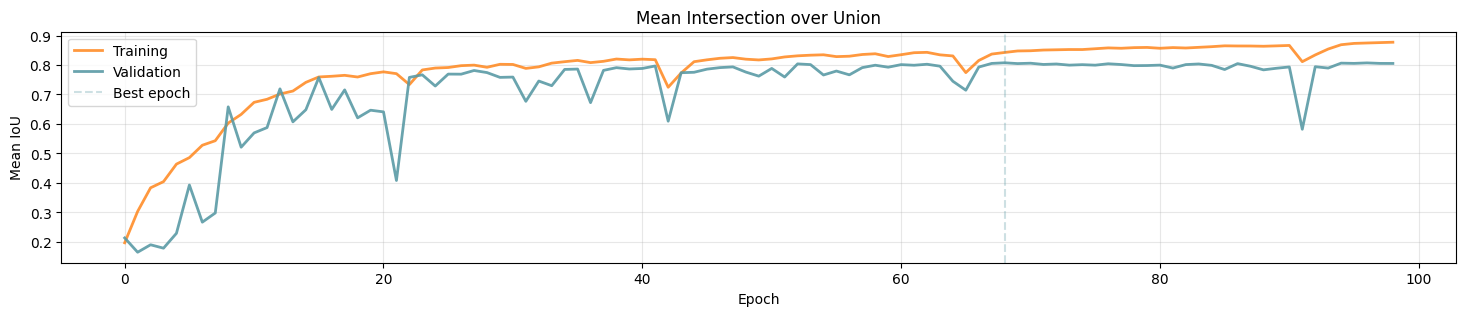

In [16]:
utils.plot_results(history)

In [17]:
# Evaluate the model on the validation set and print results
loss, accuracy, mean_iou = unet_model.evaluate(X_val, y_val, batch_size=batch_size)

print(f"Validation Loss:\t{loss}")
print(f"Validation Accuracy:\t{accuracy}")
print(f"Validation Mean IoU:\t{mean_iou}")

25/25 [==============================] - 2s 59ms/step - loss: 0.0210 - accuracy: 0.9928 - mean_iou: 0.8075
Validation Loss:	0.021017732098698616
Validation Accuracy:	0.9928410649299622
Validation Mean IoU:	0.8075278997421265


1/1 [==============================] - 0s 81ms/step


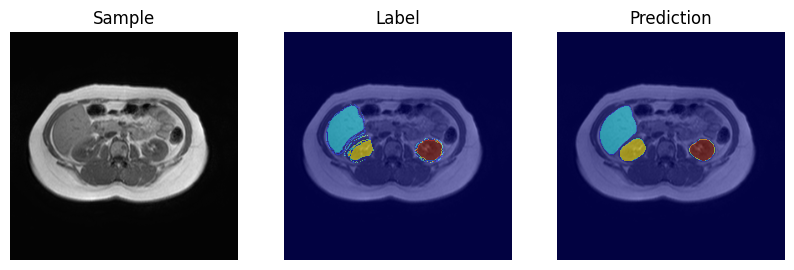

1/1 [==============================] - 0s 15ms/step


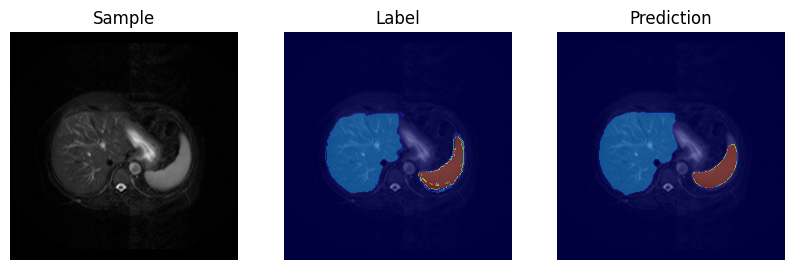

1/1 [==============================] - 0s 15ms/step


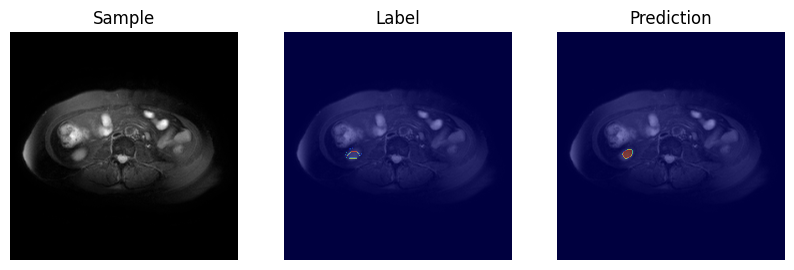

1/1 [==============================] - 0s 15ms/step


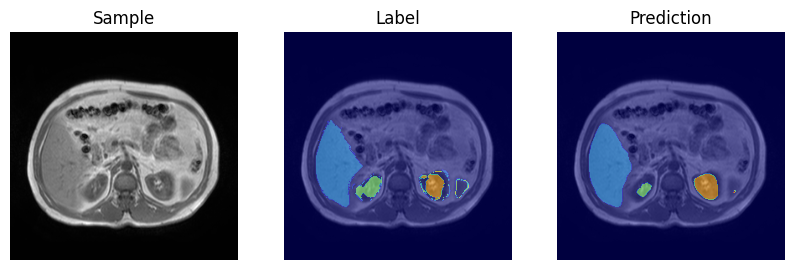

1/1 [==============================] - 0s 15ms/step


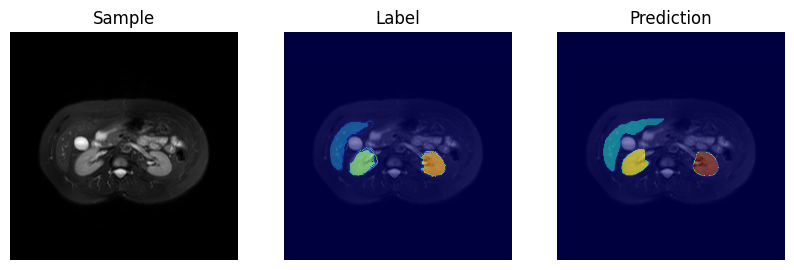

In [30]:
# Find a couple interesting samples to visualize
sample_indices = [1, 2, 3, 4, 7]

for sample_index in sample_indices:
    sample = X_val[sample_index]
    label = y_val[sample_index]

    # Plot the prediction and label
    utils.plot_prediction(unet_model, sample, label, figsize=(10, 10))

## Save and load the model

In [20]:
# Save the model and its weights
unet_model.save('models/unet.keras')
unet_model.save_weights('models/unet_weights.keras')

In [29]:
# Create a new model and load the weights
new_model = utils.get_unet_model(input_shape=input_shape, num_classes=num_classes)
new_model.load_weights('models/unet_weights.keras')

# Compile the new model
new_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', UpdatedMeanIoU(num_classes=num_classes)])

# Evaluate the new model on the validation set and print results
loss, accuracy, mean_iou = new_model.evaluate(X_val, y_val, batch_size=batch_size)

print(f"Validation Loss:\t{loss}")
print(f"Validation Accuracy:\t{accuracy}")
print(f"Validation Mean IoU:\t{mean_iou}")

25/25 [==============================] - 3s 75ms/step - loss: 0.0210 - accuracy: 0.9928 - mean_iou: 0.8075
Validation Loss:	0.021017923951148987
Validation Accuracy:	0.9928410053253174
Validation Mean IoU:	0.8075398206710815
